In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft

# expts = ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33899,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:37229,Total threads: 1
Dashboard: /proxy/37919/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:37793,


## Plot raw dissipation over long time average

In [3]:
def laplacian(data):
    out = data.u.bfill("xb",limit = 4).ffill("xb",limit = 4).differentiate("xb").differentiate("xb")
    out +=data.v.bfill("yb",limit = 4).ffill("yb",limit = 4).differentiate("yb").differentiate("yb")
    return out

def hor_dissipatoin(data):
    return (
        (data.ahh * laplacian(data)**2).mean("time") / (1e9)
    ).fillna(0).integrate("zl")

## Calculate horizontal and vertical dissipation for unfiltered velocities

In [ ]:
kvu_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-beamless-20/output004/kvu/*.nc",decode_times=False,decode_cf = False)
kvu_full = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/kvu/*.nc",decode_times=False,decode_cf = False)
ahh_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-beamless-20/output004/ahh/*.nc",decode_times=False,decode_cf = False)
ahh_full = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/ahh/*.nc",decode_times=False,decode_cf = False)
u_full = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/u/*.nc",decode_times=False,decode_cf = False)
v_full = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/v/*.nc",decode_times=False,decode_cf = False)
u_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-beamless-20/output004/u/*.nc",decode_times=False,decode_cf = False)
v_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-beamless-20/output004/v/*.nc",decode_times=False,decode_cf = False)

topo = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/bathy_transect.nc",decode_times=False,decode_cf = False)

beamless_hvisc = hor_dissipatoin(xr.merge([u_beamless,v_beamless,ahh_beamless]).isel(time = slice(0,255)))
full_hvisc = hor_dissipatoin(xr.merge([u_full,v_full,ahh_full]).isel(time = slice(0,255)))
beamless_vvisc = 1000 * kvu_beamless.kvu * (u_beamless.u.differentiate("zl") + v_beamless.v.differentiate("zl"))**2
full_vvisc = 1000 * kvu_full.kvu * (u_full.u.differentiate("zl") + v_full.v.differentiate("zl"))**2

beamless_vvisc = xr.merge([beamless_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
full_vvisc = xr.merge([full_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
beamless_hvisc = xr.merge([beamless_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load().rename("diss"),topo.rename({"depth":"bathy"})])
full_hvisc = xr.merge([full_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load().rename("diss"),topo.rename({"depth":"bathy"})])
beamless_vvisc = 1000 * kvu_beamless.kvu * (u_beamless.u.differentiate("zl") + v_beamless.v.differentiate("zl"))**2
full_vvisc = 1000 * kvu_full.kvu * (u_full.u.differentiate("zl") + v_full.v.differentiate("zl"))**2

beamless_vvisc = xr.merge([beamless_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
full_vvisc = xr.merge([full_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
beamless_hvisc = xr.merge([beamless_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load().diss.rename("diss"),topo.rename({"depth":"bathy"})])
full_hvisc = xr.merge([full_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load().diss.rename("diss"),topo.rename({"depth":"bathy"})])

def ShelfMask(data):
    return data.where(
        ((data.bathy) > -2000) & (data.xb < 200)& (np.abs(data.yb) < 80),np.nan
    ).fillna(0)

print(f"Total beamless dissipation: {(ShelfMask(beamless_vvisc).diss.integrate('zl').integrate('yb').integrate('xb') * 1e6).values / 10e6:>.1f} MW")
print(f"Total full dissipation: {(ShelfMask(full_vvisc).diss.integrate('zl').integrate('yb').integrate('xb') * 1e6).values / 10e6:>.1f} MW")
print(f"Total anomaly: {((ShelfMask(full_vvisc) - ShelfMask(beamless_vvisc)).diss.integrate('zl').integrate('yb').integrate('xb') * 1e6).values / 10e3:>.1f} kW")

Total beamless dissipation: 52.7 MW
Total full dissipation: 53.5 MW
Total anomaly: 725.9 kW


## Same but load filtered velocities instead

In [20]:
def hor_dissipatoin(data):
    return (
        (data.ahh * laplacian(data)**2) / (1e9)
    ).fillna(0).integrate("zl")

kvu_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/kvu/*.nc",decode_times=False,decode_cf = False).mean("time").isel(zl = slice(0,96))
kvu_full = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/kvu/*.nc",decode_times=False,decode_cf = False).mean("time").isel(zl = slice(0,96))
ahh_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/ahh/*.nc",decode_times=False,decode_cf = False).mean("time").isel(zl = slice(0,96))
ahh_full = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/DissipationExperiment/DE-full-20/output004/ahh/*.nc",decode_times=False,decode_cf = False).mean("time").isel(zl = slice(0,96))
u_full = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/full-20/bandpassed/t0-22000/*.nc",decode_times=False,decode_cf = False).u.assign_coords({"zl":kvu_beamless.zl.values})
v_full = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/full-20/bandpassed/t0-22000/*.nc",decode_times=False,decode_cf = False).v.assign_coords({"zl":kvu_beamless.zl.values})
u_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/beamless-20/bandpassed/t0-22000/*.nc",decode_times=False,decode_cf = False).u.assign_coords({"zl":kvu_beamless.zl.values})
v_beamless = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/beamless-20/bandpassed/t0-22000/*.nc",decode_times=False,decode_cf = False).v.assign_coords({"zl":kvu_beamless.zl.values})

topo = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/bathy_transect.nc",decode_times=False,decode_cf = False)

beamless_hvisc = hor_dissipatoin(xr.merge([u_beamless,v_beamless,ahh_beamless]).isel(time = slice(0,255)))
full_hvisc = hor_dissipatoin(xr.merge([u_full,v_full,ahh_full]).isel(time = slice(0,255)))
beamless_vvisc = 1000 * kvu_beamless.kvu * (u_beamless.differentiate("zl") + v_beamless.differentiate("zl"))**2
full_vvisc = 1000 * kvu_full.kvu * (u_full.differentiate("zl") + v_full.differentiate("zl"))**2

beamless_vvisc = xr.merge([beamless_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
full_vvisc = xr.merge([full_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
beamless_hvisc = xr.merge([beamless_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load().rename("diss"),topo.rename({"depth":"bathy"})])
full_hvisc = xr.merge([full_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load().rename("diss"),topo.rename({"depth":"bathy"})])
beamless_vvisc = 1000 * kvu_beamless.kvu * (u_beamless.differentiate("zl") + v_beamless.differentiate("zl"))**2
full_vvisc = 1000 * kvu_full.kvu * (u_full.differentiate("zl") + v_full.differentiate("zl"))**2

beamless_vvisc = xr.merge([beamless_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
full_vvisc = xr.merge([full_vvisc.sel(xb = slice(0,250),yb = slice(-120,120)).isel(time = slice(0,255)).fillna(0).mean("time").load().rename("diss"),topo.rename({"depth":"bathy"})])
beamless_hvisc = xr.merge([beamless_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load(),topo.rename({"depth":"bathy"})])
full_hvisc = xr.merge([full_hvisc.sel(xb = slice(0,250),yb = slice(-120,120)).fillna(0).load(),topo.rename({"depth":"bathy"})])

def ShelfMask(data):
    return data.where(
        ((data.bathy) > -2000) & (data.xb < 200)& (np.abs(data.yb) < 80),np.nan
    ).fillna(0)

print(f"Total beamless dissipation: {(ShelfMask(beamless_vvisc).diss.integrate('zl').integrate('yb').integrate('xb') * 1e6).values / 10e6:>.1f} MW")
print(f"Total full dissipation: {(ShelfMask(full_vvisc).diss.integrate('zl').integrate('yb').integrate('xb') * 1e6).values / 10e6:>.1f} MW")
print(f"Total anomaly: {((ShelfMask(full_vvisc) - ShelfMask(beamless_vvisc)).diss.integrate('zl').integrate('yb').integrate('xb') * 1e6).values / 10e3:>.1f} kW")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/g/data/hh5/public/a

Total beamless dissipation: 2.2 MW
Total full dissipation: 2.3 MW
Total anomaly: 142.7 kW


In [26]:
print(f"Total beamless dissipation: {(ShelfMask(beamless_hvisc).diss.mean('time').integrate('yb').integrate('xb') * 1e6).values / 10e3:>.1f} MW")
print(f"Total full dissipation: {(ShelfMask(full_hvisc).diss.mean('time').integrate('yb').integrate('xb') * 1e6).values / 10e3:>.1f} MW")
print(f"Total anomaly: {((ShelfMask(full_hvisc) - ShelfMask(beamless_hvisc)).diss.mean('time').integrate('yb').integrate('xb') * 1e6).values / 10e3:>.1f} kW")

Total beamless dissipation: 8.7 MW
Total full dissipation: 21.4 MW
Total anomaly: 12.7 kW


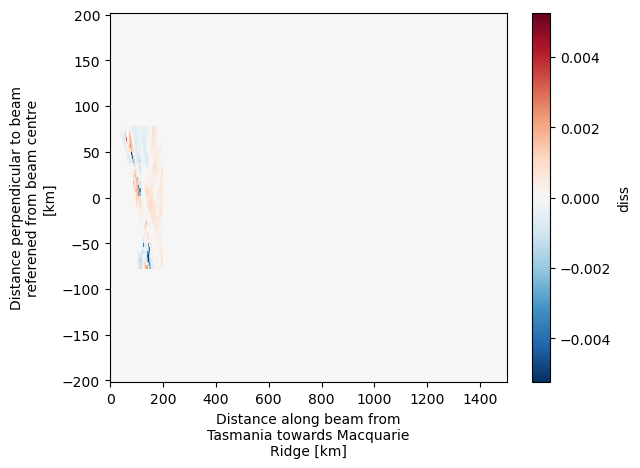

In [27]:
(ShelfMask(full_vvisc) - ShelfMask(beamless_vvisc)).diss.integrate('zl').plot()

In [16]:
u_full * beamless_vvisc

<xarray.Dataset> Size: 6kB
Dimensions:  (zl: 0, xb: 376, yb: 101, time: 233)
Coordinates:
  * zl       (zl) float64 0B 
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 808B -200.0 -196.0 -192.0 -188.0 ... 192.0 196.0 200.0
  * time     (time) float64 2kB 2.188e+04 2.188e+04 ... 2.211e+04 2.212e+04
Data variables:
    diss     (zl, time, yb, xb) float32 0B dask.array<chunksize=(0, 17, 101, 376), meta=np.ndarray>
    zi       (zl, time, yb, xb) float64 0B dask.array<chunksize=(0, 17, 101, 376), meta=np.ndarray>
    lon      (zl, time, yb, xb) float64 0B dask.array<chunksize=(0, 17, 101, 376), meta=np.ndarray>
    lat      (zl, time, yb, xb) float64 0B dask.array<chunksize=(0, 17, 101, 376), meta=np.ndarray>
    bathy    (zl, time, yb, xb) float64 0B dask.array<chunksize=(0, 17, 101, 376), meta=np.ndarray>